In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build your own Grounded RAG application using Vertex AI APIs for RAG and Langchain

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.sandbox.google.com/github/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/retrieval_augmented_generation/diy_rag_with_vertexai_apis/build_grounded_rag_app_with_vertex.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fapplied-ai-engineering-samples%2Fmain%2Fgenai-on-vertex-ai%2Fretrieval_augmented_generation%2Fdiy_rag_with_vertexai_apis%2Fbuild_grounded_rag_app_with_vertex.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/retrieval_augmented_generation/diy_rag_with_vertexai_apis/build_grounded_rag_app_with_vertex.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/retrieval_augmented_generation/diy_rag_with_vertexai_apis/build_grounded_rag_app_with_vertex.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

| | |
|-|-|
| Author(s) | [Abhishek Bhagwat](https://github.com/Abhishekbhagwat), [Rajesh Thallam](https://github.com/RajeshThallam)|
| Reviewers(s) | Alan Blount, [Holt Skinner](https://github.com/holtskinner), [Skander Hannachi](https://github.com/SkanderHn)|
| Last updated | 2024-06-18 |

# 📌 Overview

In this notebook, we show you how to use [Vertex AI Builder APIs for RAG](https://cloud.google.com/generative-ai-app-builder/docs/builder-apis) to build a custom search solution on your own documents.

---

Building a robust custom (DIY) Retrieval Augmented Generation (RAG) system for grounding can be challenging.  Vertex AI simplifies the process with a suite of flexible standalone APIs to help your create your own search solutions.

* **[Document AI Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk)**:
Transforms documents into structured representations, making content easily accessible. Creates context-aware chunks for improved information retrieval in generative AI and discovery applications.
* **[Ranking API](https://cloud.google.com/generative-ai-app-builder/docs/ranking)**: Re-ranks search results based on relevance to the original query. Enhances RAG accuracy by optimizing retrieval beyond initial nearest neighbor search.
* **[Check Grounding API](https://cloud.google.com/generative-ai-app-builder/docs/check-grounding)**: Acts as a "validator" to determine whether statements or claims are supported by provided facts (essentially how grounded a given piece of text is in a given set of reference text). Enables online flagging of ungrounded responses and offline evaluation of generative responses.

**Key Features**:
* **Leverage Vertex AI Search technology**:  Build custom RAG and Grounded Generation solutions using the same technology that powers Vertex AI Search.
* **Granular control**: Tailor your RAG system to specific use cases and offer greater control to your users.
* **Seamless integration**: Combine these APIs with core services like Embeddings API and Vector Search for advanced grounded AI applications.

These builder APIS give you full flexibility and control on the design of your RAG application while at the same time offering accelerated time to market and high quality by relying on these lower-level Vertex AI APIs. Refer to the [documentation](https://cloud.google.com/generative-ai-app-builder/docs/builder-apis) to learn more.


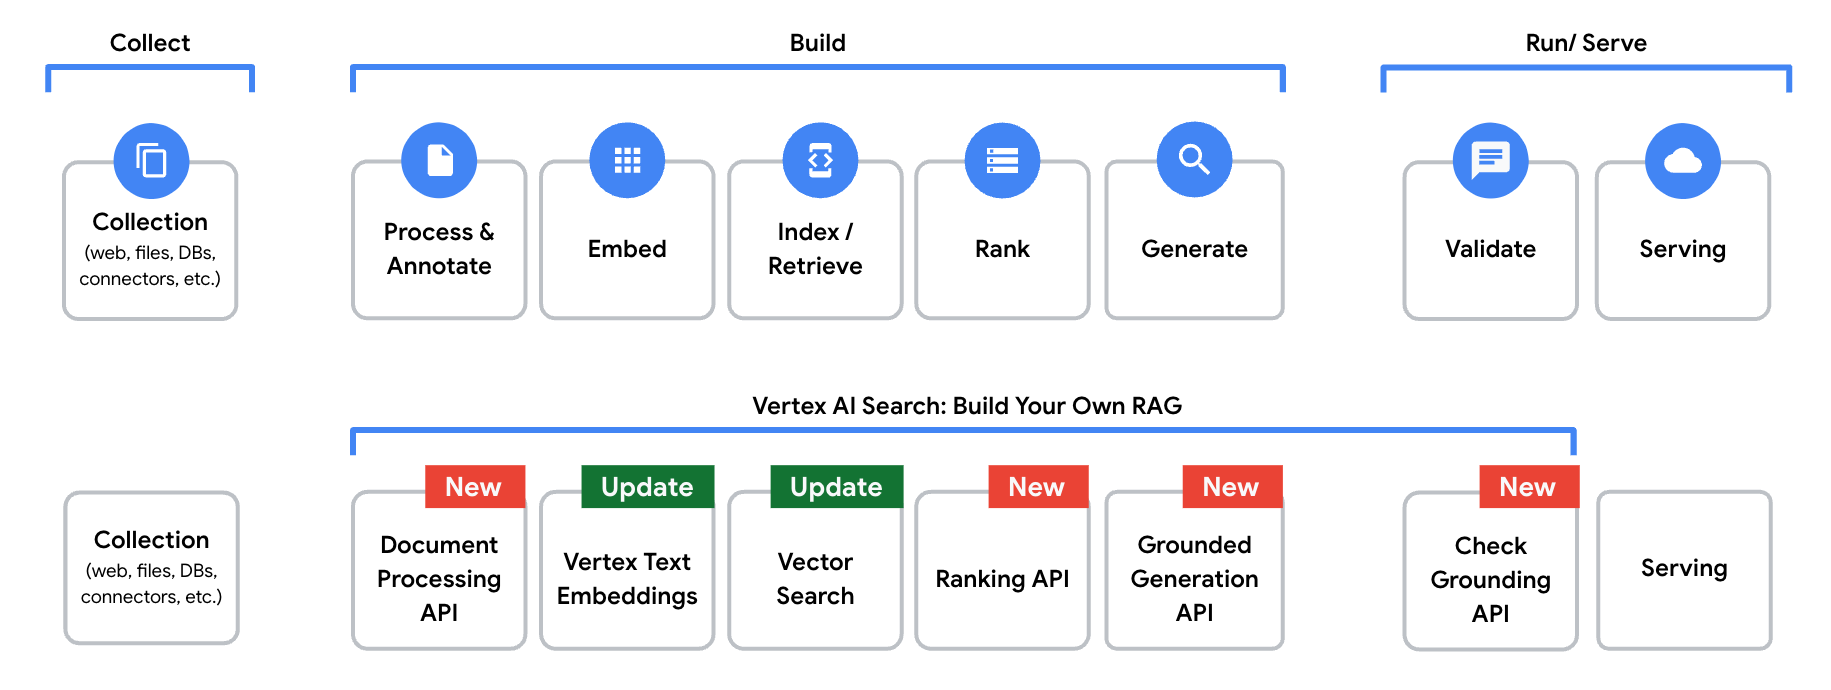

---

# 📐 Architecture

Following is a high-level architecture of what we will build in this notebook.

You will perform the following steps:

- **Step 1. Data Ingestion:** Ingest documents from Cloud Storage bucket to [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview) (vector database). You parse the documents in Cloud Storage bucket using [Cloud Document AI Layout Parser](https://cloud.google.com/document-ai/docs/layout-parse-chunk) and convert the raw text chunks as embeddings using [Vertex AI Embeddings API](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings). The generated embeddings power semantic search using Vector search.

- **Step 2. Retrieval:** Retrieve relevant chunks from the Vertex AI vector Search for a given user query and re-rank the chunks using [Vertex AI Ranking API](https://cloud.google.com/generative-ai-app-builder/docs/ranking).

- **Step 3. Answer generation:** You would use [Vertex AI Gemini API](https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts) to generate an answer for the given user query based on the re-ranked chunks retrieved from the vector search. The generated answer is validated with [Vertex AI Check Grounding API](https://cloud.google.com/generative-ai-app-builder/docs/check-grounding) to dertermine how grounded the answer is to the relevant chunks retrieved.

The notebook uses [LangChain](https://www.langchain.com/) and [Google Cloud + LangChain integrations](https://python.langchain.com/v0.1/docs/integrations/platforms/google/) to orcherate the pipeline.

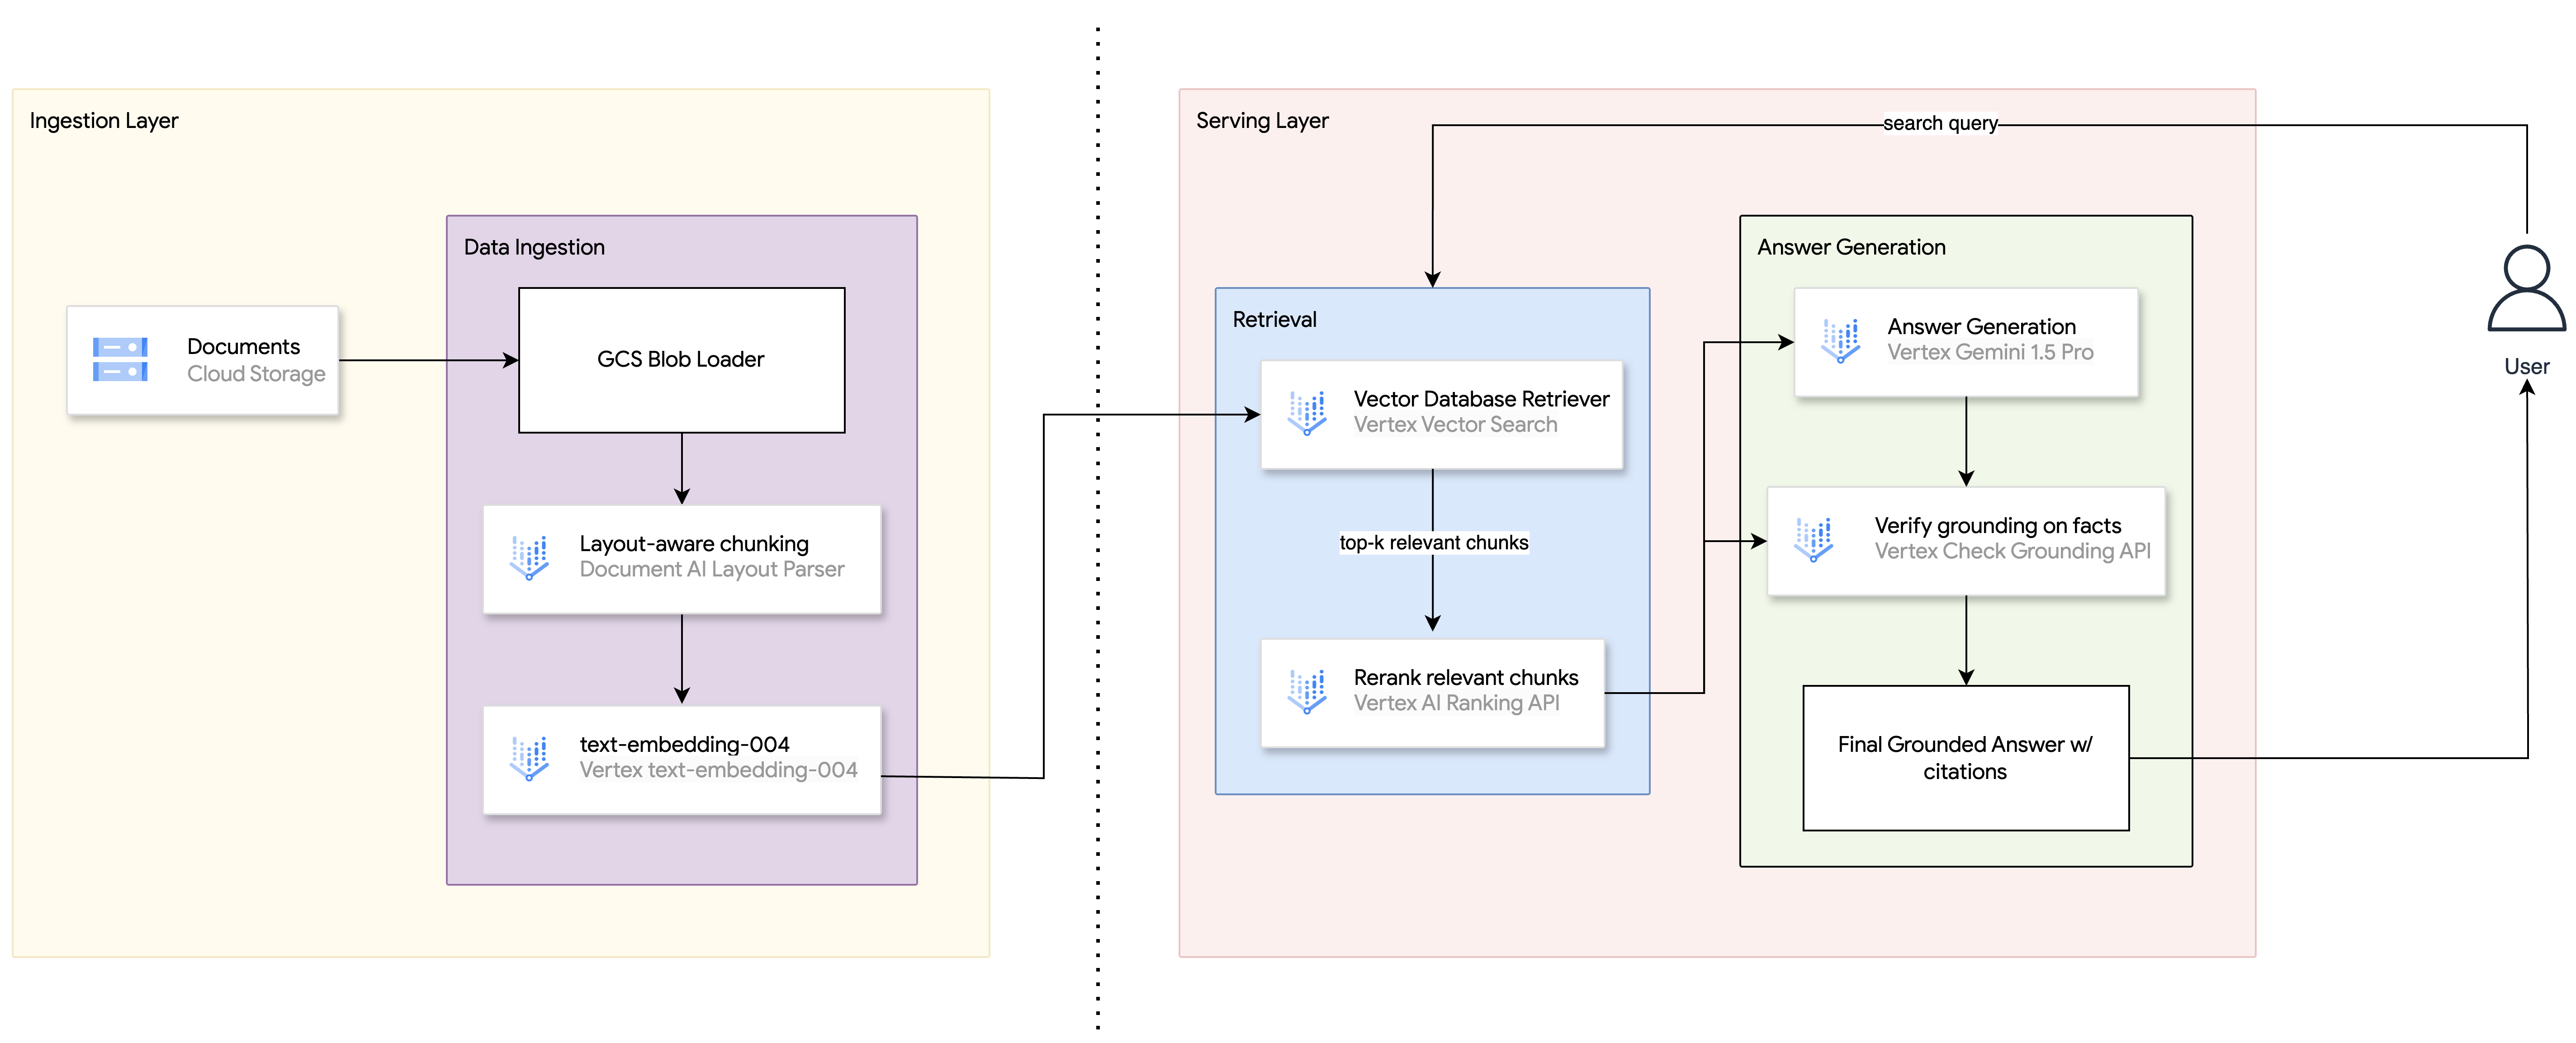

---

# 🎬 Getting Started

The following steps are necessary to run this notebook, no matter what notebook environment you're using.

If you're entirely new to Google Cloud, [get started here](https://cloud.google.com/docs/get-started).



### Google Cloud Project Setup

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.
1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).
1. [Enable the Service Usage API](https://console.cloud.google.com/apis/library/serviceusage.googleapis.com)
1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).
1. [Enable the Cloud Storage API](https://console.cloud.google.com/flows/enableapi?apiid=storage.googleapis.com).
1. [Enable the Cloud Document AI API](https://console.cloud.google.com/flows/enableapi?apiid=documentai.googleapis.com).
1. [Enable the Discovery Engine API for your project](https://console.cloud.google.com/marketplace/product/google/discoveryengine.googleapis.com).

### Google Cloud Permissions

**To run the complete Notebook, including the optional section, you will need to have the [Owner role](https://cloud.google.com/iam/docs/understanding-roles) for your project.**

If you want to skip the optional section, you need at least the following [roles](https://cloud.google.com/iam/docs/granting-changing-revoking-access):
* **`roles/serviceusage.serviceUsageAdmin`** to enable APIs
* **`roles/iam.serviceAccountAdmin`** to modify service agent permissions
* **`roles/aiplatform.user`** to use AI Platform components
* **`roles/storage.objectAdmin`** to modify and delete GCS buckets
* **`roles/documentai.admin`** to create and use Document AI Processors
* **`roles/discoveryengine.admin`** to modify Vertex AI Search assets

### Install Vertex AI SDK and Other Required Packages

In [ ]:
! pip install google-cloud-aiplatform --upgrade --quiet
! pip install google-cloud-discoveryengine --upgrade --quiet
! pip install google-cloud-documentai google-cloud-documentai-toolbox --upgrade --quiet
! pip install google-cloud-storage --upgrade --quiet

! pip install langchain-google-community --upgrade --quiet
! pip install langchain-google-vertexai --upgrade --quiet
! pip install langchain-google-community[vertexaisearch] --upgrade --quiet
! pip install langchain-google-community[docai] --upgrade --quiet

! pip install rich --upgrade --quiet

### Restart Runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

### Authenticate

If you're using Colab, run the code in the next cell. Follow the popups and authenticate with an account that has access to your Google Cloud [project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#identifying_projects).

If you're running this notebook somewhere besides Colab, make sure your environment has the right Google Cloud access. If that's a new concept to you, consider looking into [Application Default Credentials for your local environment](https://cloud.google.com/docs/authentication/provide-credentials-adc#local-dev) and [initializing the Google Cloud CLI](https://cloud.google.com/docs/authentication/gcloud). In many cases, running `gcloud auth application-default login` in a shell on the machine running the notebook kernel is sufficient.

More authentication options are discussed [here](https://cloud.google.com/docs/authentication).

In [ ]:
# Colab authentication.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()
    print("Authenticated")

### Set Google Cloud project information and Initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

Make sure to change `PROJECT_ID` in the next cell. You can leave the values for `REGION` unless you have a specific reason to change them.

In [ ]:
import vertexai
from google.cloud import documentai
from google.cloud import discoveryengine

PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=REGION)
print(f"Vertex AI SDK initialized.")
print(f"Vertex AI SDK version = {vertexai.__version__}")
print(f"Document AI API version = {documentai.__version__}")
print(f"Discovery Engine API version = {discoveryengine.__version__}")

### Initialize variables

Set the values for the name of your project. 

<div class="alert alert-block alert-info">
ⓘ You might already have all of these resources created in which case you should use their names and set <code>CREATE_RESOURCES=False</code>. If you do not already have this all created, you should set new names for your cloud storage bucket, index, index endpoint, and docai processor.
</div>

**TIP:** stick to `hyphenated-lower-case` naming conventions, and use the same project name as a component of each of these names.

In [ ]:
# Cloud storage buckets
GCS_BUCKET_URI = "gs://[your-bucket-name]"  # @param {type:"string"}
GCS_OUTPUT_PATH = f"{GCS_BUCKET_URI}"  # DocAI Layout Parser Output Path
GCS_BUCKET_NAME = GCS_BUCKET_URI.replace("gs://", "")

# Vertex AI Vector Search
# parameter description here
# https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.MatchingEngineIndex#google_cloud_aiplatform_MatchingEngineIndex_create_tree_ah_index
VS_INDEX_NAME = "[your-index-name]"  # @param {type:"string"}
VS_INDEX_ENDPOINT_NAME = "[your-index-endpoint-name]"  # @param {type:"string"}
VS_CONTENTS_DELTA_URI = f"{GCS_BUCKET_URI}/index/embeddings"
VS_DIMENSIONS = 768
VS_APPROX_NEIGHBORS = 150
VS_INDEX_UPDATE_METHOD = "STREAM_UPDATE"
VS_INDEX_SHARD_SIZE = "SHARD_SIZE_SMALL"
VS_LEAF_NODE_EMB_COUNT = 500
VS_LEAF_SEARCH_PERCENT = 80
VS_DISTANCE_MEASURE_TYPE = "DOT_PRODUCT_DISTANCE"
VS_MACHINE_TYPE = "e2-standard-16"
VS_MIN_REPLICAS = 1
VS_MAX_REPLICAS = 1
VS_DESCRIPTION = "Index for DIY RAG with Vertex AI APIs"  # @param {type:"string"}

# Models
EMBEDDINGS_MODEL_NAME = "text-embedding-004"
LLM_MODEL_NAME = "gemini-1.5-pro"

# DocumentAI Processor
DOCAI_LOCATION = "us"  # @param ["us", "eu"]
DOCAI_PROCESSOR_NAME = "[your-docai-processor-name]"  # @param {type:"string"}

# Enable/disable flags
# flag to create Google Cloud resources configured above
# refer to the notes before this cell
CREATE_RESOURCES = False  # @param {type:"boolean"}
# flag to run data ingestion
RUN_INGESTION = True  # @param {type:"boolean"}

### Utility functions and Custom LangChain Components

We define a few custom LangChain components until these components are merged in the Google Cloud + LangChain integrations.

In [ ]:
# @title Document AI LangChain Integration
"""Module contains a PDF parser based on Document AI from Google Cloud.

You need to install two libraries to use this parser:
pip install google-cloud-documentai
pip install google-cloud-documentai-toolbox
"""

import logging
import re
import time
from dataclasses import dataclass
from typing import TYPE_CHECKING, Iterator, List, Optional, Sequence

from langchain_core.document_loaders import BaseBlobParser
from langchain_core.document_loaders.blob_loaders import Blob
from langchain_core.documents import Document
from langchain_core.utils.iter import batch_iterate

from langchain_google_community._utils import get_client_info

if TYPE_CHECKING:
    from google.api_core.operation import Operation  # type: ignore[import]
    from google.cloud.documentai import (  # type: ignore[import]
        DocumentProcessorServiceClient,
    )


logger = logging.getLogger(__name__)


@dataclass
class DocAIParsingResults:
    """A dataclass to store Document AI parsing results."""

    source_path: str
    parsed_path: str


class DocAIParser(BaseBlobParser):
    """`Google Cloud Document AI` parser.

    For a detailed explanation of Document AI, refer to the product documentation.
    https://cloud.google.com/document-ai/docs/overview
    """

    def __init__(
        self,
        *,
        client: Optional["DocumentProcessorServiceClient"] = None,
        project_id: Optional[str] = None,
        location: Optional[str] = None,
        gcs_output_path: Optional[str] = None,
        processor_name: Optional[str] = None,
    ) -> None:
        """Initializes the parser.

        Args:
            client: a DocumentProcessorServiceClient to use
            location: a Google Cloud location where a Document AI processor is located
            gcs_output_path: a path on Google Cloud Storage to store parsing results
            processor_name: full resource name of a Document AI processor or processor
                version

        You should provide either a client or location (and then a client
            would be instantiated).
        """

        if bool(client) == bool(location):
            raise ValueError(
                "You must specify either a client or a location to instantiate "
                "a client."
            )

        pattern = r"projects\/[0-9]+\/locations\/[a-z\-0-9]+\/processors\/[a-z0-9]+"
        if processor_name and not re.fullmatch(pattern, processor_name):
            raise ValueError(
                f"Processor name {processor_name} has the wrong format. If your "
                "prediction endpoint looks like https://us-documentai.googleapis.com"
                "/v1/projects/PROJECT_ID/locations/us/processors/PROCESSOR_ID:process,"
                " use only projects/PROJECT_ID/locations/us/processors/PROCESSOR_ID "
                "part."
            )

        self._gcs_output_path = gcs_output_path
        self._processor_name = processor_name
        if client:
            self._client = client
        else:
            try:
                from google.api_core.client_options import ClientOptions
                from google.cloud.documentai import DocumentProcessorServiceClient
            except ImportError as exc:
                raise ImportError(
                    "Could not import google-cloud-documentai python package. "
                    "Please, install docai dependency group: "
                    "`pip install langchain-google-community[docai]`"
                ) from exc
            options = ClientOptions(
                quota_project_id=project_id,
                api_endpoint=f"{location}-documentai.googleapis.com",
            )
            self._client = DocumentProcessorServiceClient(
                client_options=options,
                client_info=get_client_info(module="document-ai"),
            )
            # get processor type
            self._processor_type = self._client.get_processor(name=processor_name).type
            if self._processor_type == "LAYOUT_PARSER_PROCESSOR":
                self._use_layout_parser = True
            else:
                self._use_layout_parser = False

    def lazy_parse(self, blob: Blob) -> Iterator[Document]:
        """Parses a blob lazily.

        Args:
            blobs: a Blob to parse

        This is a long-running operation. A recommended way is to batch
            documents together and use the `batch_parse()` method.
        """
        yield from self.batch_parse([blob], gcs_output_path=self._gcs_output_path)

    def online_process(
        self,
        blob: Blob,
        enable_native_pdf_parsing: bool = True,
        field_mask: Optional[str] = None,
        page_range: Optional[List[int]] = None,
        chunk_size: int = 500,
        include_ancestor_headings: bool = True,
    ) -> Iterator[Document]:
        """Parses a blob lazily using online processing.

        Args:
            blob: a blob to parse.
            enable_native_pdf_parsing: enable pdf embedded text extraction
            field_mask: a comma-separated list of which fields to include in the
                Document AI response.
                suggested: "text,pages.pageNumber,pages.layout"
            page_range: list of page numbers to parse. If `None`,
                entire document will be parsed.
            chunk_size: the maximum number of characters per chunk
            include_ancestor_headings: whether to include ancestor headings in the chunks
                https://cloud.google.com/document-ai/docs/reference/rpc/google.cloud.documentai.v1beta3#chunkingconfig
        """
        try:
            from google.cloud import documentai
            from google.cloud.documentai_v1.types import (  # type: ignore[import, attr-defined]
                OcrConfig,
                ProcessOptions,
            )
        except ImportError as exc:
            raise ImportError(
                "Could not import google-cloud-documentai python package. "
                "Please, install docai dependency group: "
                "`pip install langchain-google-community[docai]`"
            ) from exc
        try:
            from google.cloud.documentai_toolbox.wrappers.page import (  # type: ignore[import]
                _text_from_layout,
            )
        except ImportError as exc:
            raise ImportError(
                "documentai_toolbox package not found, please install it with "
                "`pip install langchain-google-community[docai]`"
            ) from exc

        if self._use_layout_parser:
            layout_config = ProcessOptions.LayoutConfig(
                chunking_config=ProcessOptions.LayoutConfig.ChunkingConfig(
                    chunk_size=chunk_size,
                    include_ancestor_headings=include_ancestor_headings,
                )
            )
            individual_page_selector = (
                ProcessOptions.IndividualPageSelector(pages=page_range)
                if page_range
                else None
            )
            process_options = ProcessOptions(
                layout_config=layout_config,
                individual_page_selector=individual_page_selector,
            )
        else:
            ocr_config = (
                OcrConfig(enable_native_pdf_parsing=enable_native_pdf_parsing)
                if enable_native_pdf_parsing
                else None
            )
            individual_page_selector = (
                ProcessOptions.IndividualPageSelector(pages=page_range)
                if page_range
                else None
            )
            process_options = ProcessOptions(
                ocr_config=ocr_config, individual_page_selector=individual_page_selector
            )

        response = self._client.process_document(
            documentai.ProcessRequest(
                name=self._processor_name,
                gcs_document=documentai.GcsDocument(
                    gcs_uri=blob.path,
                    mime_type=blob.mimetype or "application/pdf",
                ),
                process_options=process_options,
                skip_human_review=True,
                field_mask=field_mask,
            )
        )

        if self._use_layout_parser:
            yield from (
                Document(
                    page_content=chunk.content,
                    metadata={
                        "chunk_id": chunk.chunk_id,
                        "source": blob.path,
                    },
                )
                for chunk in response.document.chunked_document.chunks
            )
        else:
            yield from (
                Document(
                    page_content=_text_from_layout(page.layout, response.document.text),
                    metadata={
                        "page": page.page_number,
                        "source": blob.path,
                    },
                )
                for page in response.document.pages
            )

    def batch_parse(
        self,
        blobs: Sequence[Blob],
        gcs_output_path: Optional[str] = None,
        timeout_sec: int = 3600,
        check_in_interval_sec: int = 60,
        chunk_size: int = 500,
        include_ancestor_headings: bool = True,
    ) -> Iterator[Document]:
        """Parses a list of blobs lazily.

        Args:
            blobs: a list of blobs to parse.
            gcs_output_path: a path on Google Cloud Storage to store parsing results.
            timeout_sec: a timeout to wait for Document AI to complete, in seconds.
            check_in_interval_sec: an interval to wait until next check
                whether parsing operations have been completed, in seconds
        This is a long-running operation. A recommended way is to decouple
            parsing from creating LangChain Documents:
            >>> operations = parser.docai_parse(blobs, gcs_path)
            >>> parser.is_running(operations)
            You can get operations names and save them:
            >>> names = [op.operation.name for op in operations]
            And when all operations are finished, you can use their results:
            >>> operations = parser.operations_from_names(operation_names)
            >>> results = parser.get_results(operations)
            >>> docs = parser.parse_from_results(results)
        """
        output_path = gcs_output_path or self._gcs_output_path
        if not output_path:
            raise ValueError(
                "An output path on Google Cloud Storage should be provided."
            )
        operations = self.docai_parse(
            blobs,
            gcs_output_path=output_path,
            chunk_size=chunk_size,
            include_ancestor_headings=include_ancestor_headings,
        )
        operation_names = [op.operation.name for op in operations]
        logger.debug(
            "Started parsing with Document AI, submitted operations %s", operation_names
        )
        time_elapsed = 0
        while self.is_running(operations):
            time.sleep(check_in_interval_sec)
            time_elapsed += check_in_interval_sec
            if time_elapsed > timeout_sec:
                raise TimeoutError(
                    "Timeout exceeded! Check operations " f"{operation_names} later!"
                )
            logger.debug(".")

        results = self.get_results(operations=operations)
        yield from self.parse_from_results(results)

    def parse_from_results(
        self, results: List[DocAIParsingResults]
    ) -> Iterator[Document]:
        try:
            from google.cloud.documentai_toolbox.utilities.gcs_utilities import (  # type: ignore[import]
                split_gcs_uri,
            )
            from google.cloud.documentai_toolbox.wrappers.document import (  # type: ignore[import]
                _get_shards,
            )
            from google.cloud.documentai_toolbox.wrappers.page import _text_from_layout
        except ImportError as exc:
            raise ImportError(
                "documentai_toolbox package not found, please install it with "
                "`pip install langchain-google-community[docai]`"
            ) from exc
        for result in results:
            print(f"processing: {result.parsed_path}")
            gcs_bucket_name, gcs_prefix = split_gcs_uri(result.parsed_path)
            shards = _get_shards(gcs_bucket_name, gcs_prefix + "/")
            if self._use_layout_parser:
                yield from (
                    Document(
                        page_content=chunk.content,
                        metadata={
                            "chunk_id": chunk.chunk_id,
                            "source": result.source_path,
                        },
                    )
                    for shard in shards
                    for chunk in shard.chunked_document.chunks
                )
            else:
                yield from (
                    Document(
                        page_content=_text_from_layout(page.layout, shard.text),
                        metadata={
                            "page": page.page_number,
                            "source": result.source_path,
                        },
                    )
                    for shard in shards
                    for page in shard.pages
                )

    def operations_from_names(self, operation_names: List[str]) -> List["Operation"]:
        """Initializes Long-Running Operations from their names."""
        try:
            from google.longrunning.operations_pb2 import (  # type: ignore[import]
                GetOperationRequest,
            )
        except ImportError as exc:
            raise ImportError(
                "long running operations package not found, please install it with"
                "`pip install langchain-google-community[docai]`"
            ) from exc

        return [
            self._client.get_operation(request=GetOperationRequest(name=name))
            for name in operation_names
        ]

    def is_running(self, operations: List["Operation"]) -> bool:
        return any(not op.done() for op in operations)

    def docai_parse(
        self,
        blobs: Sequence[Blob],
        *,
        gcs_output_path: Optional[str] = None,
        processor_name: Optional[str] = None,
        batch_size: int = 1000,
        enable_native_pdf_parsing: bool = True,
        field_mask: Optional[str] = None,
        chunk_size: Optional[int] = 500,
        include_ancestor_headings: Optional[bool] = True,
    ) -> List["Operation"]:
        """Runs Google Document AI PDF Batch Processing on a list of blobs.

        Args:
            blobs: a list of blobs to be parsed
            gcs_output_path: a path (folder) on GCS to store results
            processor_name: name of a Document AI processor.
            batch_size: amount of documents per batch
            enable_native_pdf_parsing: a config option for the parser
            field_mask: a comma-separated list of which fields to include in the
                Document AI response.
                suggested: "text,pages.pageNumber,pages.layout"
            chunking_config: Serving config for chunking when using layout
                parser processor. Specify config parameters as dictionary elements.
                https://cloud.google.com/document-ai/docs/reference/rpc/google.cloud.documentai.v1beta3#chunkingconfig

        Document AI has a 1000 file limit per batch, so batches larger than that need
        to be split into multiple requests.
        Batch processing is an async long-running operation
        and results are stored in a output GCS bucket.
        """
        try:
            from google.cloud import documentai
            from google.cloud.documentai_v1.types import OcrConfig, ProcessOptions
        except ImportError as exc:
            raise ImportError(
                "documentai package not found, please install it with "
                "`pip install langchain-google-community[docai]`"
            ) from exc

        output_path = gcs_output_path or self._gcs_output_path
        if output_path is None:
            raise ValueError(
                "An output path on Google Cloud Storage should be provided."
            )
        processor_name = processor_name or self._processor_name
        if processor_name is None:
            raise ValueError("A Document AI processor name should be provided.")

        operations = []
        for batch in batch_iterate(size=batch_size, iterable=blobs):
            input_config = documentai.BatchDocumentsInputConfig(
                gcs_documents=documentai.GcsDocuments(
                    documents=[
                        documentai.GcsDocument(
                            gcs_uri=blob.path,
                            mime_type=blob.mimetype or "application/pdf",
                        )
                        for blob in batch
                    ]
                )
            )

            output_config = documentai.DocumentOutputConfig(
                gcs_output_config=documentai.DocumentOutputConfig.GcsOutputConfig(
                    gcs_uri=output_path, field_mask=field_mask
                )
            )

            if self._use_layout_parser:
                layout_config = ProcessOptions.LayoutConfig(
                    chunking_config=ProcessOptions.LayoutConfig.ChunkingConfig(
                        chunk_size=chunk_size,
                        include_ancestor_headings=include_ancestor_headings,
                    )
                )
                process_options = ProcessOptions(layout_config=layout_config)
            else:
                process_options = (
                    ProcessOptions(
                        ocr_config=OcrConfig(
                            enable_native_pdf_parsing=enable_native_pdf_parsing
                        )
                    )
                    if enable_native_pdf_parsing
                    else None
                )
            operations.append(
                self._client.batch_process_documents(
                    documentai.BatchProcessRequest(
                        name=processor_name,
                        input_documents=input_config,
                        document_output_config=output_config,
                        process_options=process_options,
                        skip_human_review=True,
                    )
                )
            )
        return operations

    def get_results(self, operations: List["Operation"]) -> List[DocAIParsingResults]:
        try:
            from google.cloud.documentai_v1 import (  # type: ignore[import]
                BatchProcessMetadata,
            )
        except ImportError as exc:
            raise ImportError(
                "documentai package not found, please install it with "
                "`pip install langchain-google-community[docai]`"
            ) from exc

        return [
            DocAIParsingResults(
                source_path=status.input_gcs_source,
                parsed_path=status.output_gcs_destination,
            )
            for op in operations
            for status in (
                op.metadata.individual_process_statuses
                if isinstance(op.metadata, BatchProcessMetadata)
                else BatchProcessMetadata.deserialize(
                    op.metadata.value
                ).individual_process_statuses
            )
        ]

In [ ]:
# @title Custom Cloud Storage Loader

import logging
from langchain_community.document_loaders.base import BaseLoader
from langchain_community.document_loaders.gcs_directory import GCSDirectoryLoader
from langchain_community.document_loaders.gcs_file import GCSFileLoader
from langchain_community.utilities.vertexai import get_client_info
import re

logger = logging.getLogger(__name__)


class CustomGCSDirectoryLoader(GCSDirectoryLoader, BaseLoader):
    def load(self, file_pattern=None) -> List[Document]:
        """Load documents."""
        try:
            from google.cloud import storage
        except ImportError:
            raise ImportError(
                "Could not import google-cloud-storage python package. "
                "Please install it with `pip install google-cloud-storage`."
            )
        client = storage.Client(
            project=self.project_name,
            client_info=get_client_info(module="google-cloud-storage"),
        )
        
        regex = None
        if file_pattern:
            regex = re.compile(r'{}'.format(file_pattern))

        docs = []
        for blob in client.list_blobs(self.bucket, prefix=self.prefix):
            # we shall just skip directories since GCSFileLoader creates
            # intermediate directories on the fly
            if blob.name.endswith("/"):
                continue
            if regex and not regex.match(blob.name):
                continue
            # Use the try-except block here
            try:
                logger.info(f"Processing {blob.name}")
                temp_blob = Blob(path=f"gs://{blob.bucket.name}/{blob.name}")
                docs.append(temp_blob)
            except Exception as e:
                if self.continue_on_failure:
                    logger.warning(f"Problem processing blob {blob.name}, message: {e}")
                    continue
                else:
                    raise e
        return docs

In [ ]:
# @title Utility function to create resources
import hashlib
import uuid

from google.cloud import storage
from google.cloud import aiplatform
from google.cloud import documentai
from google.api_core.client_options import ClientOptions
from google.cloud.aiplatform import MatchingEngineIndex, MatchingEngineIndexEndpoint


def create_uuid(name: str) -> str:
    hex_string = hashlib.md5(name.encode("UTF-8")).hexdigest()
    return str(uuid.UUID(hex=hex_string))


def create_bucket(bucket_name: str) -> storage.Bucket:
    # create Cloud Storage bucket if does not exists
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    if bucket.exists():
        print(f"Bucket {bucket.name} exists")
        return bucket

    if not CREATE_RESOURCES:
        return bucket

    bucket = storage_client.create_bucket(bucket_name)
    print(f"Bucket {bucket.name} created")
    return bucket


def create_index() -> Optional[MatchingEngineIndex]:
    index_names = [
        index.resource_name
        for index in MatchingEngineIndex.list(filter=f"display_name={VS_INDEX_NAME}")
    ]

    if len(index_names) > 0:
        vs_index = MatchingEngineIndex(index_name=index_names[0])
        print(
            f"Vector Search index {vs_index.display_name} exists with resource name {vs_index.resource_name}"
        )
        return vs_index

    if not CREATE_RESOURCES:
        print(
            f"CREATE_RESOURCES flag set to {CREATE_RESOURCES}. Skip creating resources"
        )
        return None

    print(f"Creating Vector Search index {VS_INDEX_NAME} ...")
    vs_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
        display_name=VS_INDEX_NAME,
        dimensions=VS_DIMENSIONS,
        approximate_neighbors_count=VS_APPROX_NEIGHBORS,
        distance_measure_type=VS_DISTANCE_MEASURE_TYPE,
        leaf_node_embedding_count=VS_LEAF_NODE_EMB_COUNT,
        leaf_nodes_to_search_percent=VS_LEAF_SEARCH_PERCENT,
        description=VS_DESCRIPTION,
        shard_size=VS_INDEX_SHARD_SIZE,
        index_update_method=VS_INDEX_UPDATE_METHOD,
        project=PROJECT_ID,
        location=REGION,
    )
    print(
        f"Vector Search index {vs_index.display_name} created with resource name {vs_index.resource_name}"
    )
    return vs_index


def create_index_endpoint() -> Optional[MatchingEngineIndexEndpoint]:
    endpoint_names = [
        endpoint.resource_name
        for endpoint in MatchingEngineIndexEndpoint.list(
            filter=f"display_name={VS_INDEX_ENDPOINT_NAME}"
        )
    ]

    if len(endpoint_names) > 0:
        vs_endpoint = MatchingEngineIndexEndpoint(index_endpoint_name=endpoint_names[0])
        print(
            f"Vector Search index endpoint {vs_endpoint.display_name} exists with resource name {vs_endpoint.resource_name}"
        )
        return vs_endpoint

    if not CREATE_RESOURCES:
        print(
            f"CREATE_RESOURCES flag set to {CREATE_RESOURCES}. Skip creating resources"
        )
        return None

    print(f"Creating Vector Search index endpoint {VS_INDEX_ENDPOINT_NAME} ...")
    vs_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
        display_name=VS_INDEX_ENDPOINT_NAME,
        public_endpoint_enabled=True,
        description=VS_DESCRIPTION,
        project=PROJECT_ID,
        location=REGION,
    )
    print(
        f"Vector Search index endpoint {vs_endpoint.display_name} created with resource name {vs_endpoint.resource_name}"
    )
    return vs_endpoint


def deploy_index(
    index: MatchingEngineIndex, endpoint: MatchingEngineIndexEndpoint
) -> Optional[MatchingEngineIndexEndpoint]:
    index_endpoints = [
        (deployed_index.index_endpoint, deployed_index.deployed_index_id)
        for deployed_index in index.deployed_indexes
    ]

    if len(index_endpoints) > 0:
        vs_deployed_index = MatchingEngineIndexEndpoint(
            index_endpoint_name=index_endpoints[0][0]
        )
        print(
            f"Vector Search index {index.display_name} is already deployed at endpoint {vs_deployed_index.display_name}"
        )
        return vs_deployed_index

    if not CREATE_RESOURCES:
        print(
            f"CREATE_RESOURCES flag set to {CREATE_RESOURCES}. Skip creating resources"
        )
        return None

    print(
        f"Deploying Vector Search index {index.display_name} at endpoint {endpoint.display_name} ..."
    )
    deployed_index_id = (
        f'{VS_INDEX_NAME}_{create_uuid(VS_INDEX_NAME).split("-")[-1]}'.replace("-", "_")
    )
    vs_deployed_index = endpoint.deploy_index(
        index=index,
        deployed_index_id=deployed_index_id,
        display_name=VS_INDEX_NAME,
        machine_type=VS_MACHINE_TYPE,
        min_replica_count=VS_MIN_REPLICAS,
        max_replica_count=VS_MAX_REPLICAS,
    )
    print(
        f"Vector Search index {index.display_name} is deployed at endpoint {vs_deployed_index.display_name}"
    )
    return vs_deployed_index


def create_docai_processor(
    processor_display_name: str = DOCAI_PROCESSOR_NAME,
    processor_type: str = "LAYOUT_PARSER_PROCESSOR",
) -> Optional[documentai.Processor]:
    # Set the api_endpoint if you use a location other than 'us'
    opts = ClientOptions(api_endpoint=f"{DOCAI_LOCATION}-documentai.googleapis.com")
    docai_client = documentai.DocumentProcessorServiceClient(client_options=opts)
    parent = docai_client.common_location_path(PROJECT_ID, DOCAI_LOCATION)
    # Check if processor exists
    processor_list = docai_client.list_processors(parent=parent)
    processors = [
        processor.name
        for processor in processor_list
        if (
            processor.display_name == processor_display_name
            and processor.type_ == processor_type
        )
    ]

    if len(processors) > 0:
        docai_processor = docai_client.get_processor(name=processors[0])
        print(
            f"Document AI processor {docai_processor.display_name} is already created"
        )
        return docai_processor

    if not CREATE_RESOURCES:
        print(
            f"CREATE_RESOURCES flag set to {CREATE_RESOURCES}. Skip creating resources"
        )
        return None

    # Create a processor
    print(
        f"Creating Document AI processor {processor_display_name} of type {processor_type} ..."
    )
    docai_processor = docai_client.create_processor(
        parent=parent,
        processor=documentai.Processor(
            display_name=processor_display_name, type_=processor_type
        ),
    )
    print(
        f"Document AI processor {processor_display_name} of type {processor_type} is created."
    )
    return docai_processor

In [ ]:
# @title Utility methods for adding index to Vertex AI Vector Search
def get_batches(items: List, n: int = 1000) -> List[List]:
    n = max(1, n)
    return [items[i : i + n] for i in range(0, len(items), n)]


def add_data(vector_store, chunks) -> None:
    if RUN_INGESTION:
        batch_size = 1000
        texts = get_batches([chunk.page_content for chunk in chunks], n=batch_size)
        metadatas = get_batches([chunk.metadata for chunk in chunks], n=batch_size)

        for i, (b_texts, b_metadatas) in enumerate(zip(texts, metadatas)):
            print(f"Adding {len(b_texts)} data points to index")
            is_complete_overwrite = bool(i == 0)
            vector_store.add_texts(
                texts=b_texts,
                metadatas=b_metadatas,
                is_complete_overwrite=is_complete_overwrite,
            )
    else:
        print("Skipping ingestion. Enable `RUN_INGESTION` flag")

In [ ]:
# @title Utility methods for displaying rich content results
from IPython.display import display, HTML
import markdown as md


def get_chunk_content(results: List) -> List:
    return [
        doc.page_content.replace("\n", "<br>")
        + f'<br><br> <b><a href="">Source: {doc.metadata.get("source")}</a></b>'
        for doc in results
    ][:5]


CONTRASTING_COLORS = [
    "rgba(255, 0, 0, 0.2)",  # Semi-transparent red
    "rgba(0, 255, 0, 0.2)",  # Semi-transparent green
    "rgba(0, 0, 255, 0.2)",  # Semi-transparent blue
    "rgba(255, 255, 0, 0.2)",  # Semi-transparent yellow
    "rgba(0, 255, 255, 0.2)",  # Semi-transparent cyan
    "rgba(255, 0, 255, 0.2)",  # Semi-transparent magenta
    "rgba(255, 165, 0, 0.2)",  # Semi-transparent orange
    "rgba(255, 105, 180, 0.2)",  # Semi-transparent pink
    "rgba(75, 0, 130, 0.2)",  # Semi-transparent indigo
    "rgba(255, 192, 203, 0.2)",  # Semi-transparent light pink
    "rgba(64, 224, 208, 0.2)",  # Semi-transparent turquoise
    "rgba(128, 0, 128, 0.2)",  # Semi-transparent purple
    "rgba(210, 105, 30, 0.2)",  # Semi-transparent chocolate
    "rgba(220, 20, 60, 0.2)",  # Semi-transparent crimson
    "rgba(95, 158, 160, 0.2)",  # Semi-transparent cadet blue
    "rgba(255, 99, 71, 0.2)",  # Semi-transparent tomato
    "rgba(144, 238, 144, 0.2)",  # Semi-transparent light green
    "rgba(70, 130, 180, 0.2)",  # Semi-transparent steel blue
]


def convert_markdown_to_html(text: str) -> str:
    # Convert Markdown to HTML, ensuring embedded HTML is preserved and interpreted correctly.
    md_extensions = [
        "extra",
        "abbr",
        "attr_list",
        "def_list",
        "fenced_code",
        "footnotes",
        "md_in_html",
        "tables",
        "admonition",
        "codehilite",
        "legacy_attrs",
        "legacy_em",
        "meta",
        "nl2br",
        "sane_lists",
        "smarty",
        "toc",
        "wikilinks",
    ]
    return str(md.markdown(text, extensions=md_extensions))


# Utility function to create HTML table with colored results
def display_html_table(simple_results: List[str], reranked_results: List[str]) -> None:
    # Find all unique values in both lists
    unique_values = set(simple_results + reranked_results)

    # Ensure we have enough colors for all unique values
    # If not, colors will repeat, which might not be ideal but is necessary if the number of unique values exceeds the number of colors
    colors = CONTRASTING_COLORS * (len(unique_values) // len(CONTRASTING_COLORS) + 1)

    # Create a dictionary to map each unique value to a color
    color_map = dict(zip(unique_values, colors))

    # Initialize the HTML table with style for equal column widths
    html = """
    <style>
    td, th {
        padding: 8px;
        text-align: left;
        border-bottom: 1px solid #ddd;
        color: #000;
    }
    tr {background-color: #ffffff;}
    /* Set table layout to fixed to respect column widths */
    table {
        table-layout: fixed;
        width: 100%; /* You can adjust the overall table width as needed */
        max-height: 100vh !important; /* Set the maximum height of the table */
        overflow-y: auto; /* Add a vertical scrollbar if the content exceeds the maximum height */
    }
    /* Set equal width for both columns */
    td, th {
        width: 50%;
    }
    .text-black {
        color: #000; /* Set the text color to black */
    }
    </style>
    <table>
    <tr><th>Retriever Results</th><th>Reranked Results</th></tr>
    """
    # Iterate over the results and assign the corresponding color to each cell
    for simple, reranked in zip(simple_results, reranked_results):
        html += f"""
        <tr>
            <td style='color: black; background-color: {color_map[simple]}; font-size: 8px;'>
                <p class='text-black'>{convert_markdown_to_html(simple)}</p>
            </td>
            <td style='color: black; background-color: {color_map[reranked]}; font-size: 8px;'>
                <p class='text-black'>{convert_markdown_to_html(reranked)}</p>
            </td>
        </tr>
        """
    html += "</table>"
    display(HTML(html))


def get_sxs_comparison(
    simple_retriever, reranking_api_retriever, query, search_kwargs
) -> List:
    simple_results = get_chunk_content(
        simple_retriever.invoke(query, search_kwargs=search_kwargs)
    )
    reranked_results = get_chunk_content(
        reranking_api_retriever.invoke(query, search_kwargs=search_kwargs)
    )
    display_html_table(simple_results, reranked_results)

    return reranked_results


def display_grounded_generation(response) -> None:
    # Extract the answer with citations and cited chunks
    answer_with_citations = response.answer_with_citations
    cited_chunks = response.cited_chunks

    # Build HTML for the chunks
    chunks_html = "".join(
        [
            f"<div id='chunk-{index}' class='chunk'>"
            + f"<div class='source'>Source {index}: <a href='{chunk['source'].metadata['source']}' target='_blank'>{chunk['source'].metadata['source']}</a></div>"
            + f"<p>{chunk['chunk_text']}</p>"
            + "</div>"
            for index, chunk in enumerate(cited_chunks)
        ]
    )

    # Replace citation indices with hoverable spans
    for index in range(len(cited_chunks)):
        answer_with_citations = answer_with_citations.replace(
            f"[{index}]",
            f"<span class='citation' onmouseover='highlight({index})' onmouseout='unhighlight({index})'>[{index}]</span>",
        )

    # The complete HTML
    html_content = f"""
    <style>
    body {{
        font-family: Arial, sans-serif;
        background-color: #e7f0fd;
        padding: 20px;
    }}
    .answer-box {{
        background-color: #f8f9fa;
        border-left: 4px solid #0056b3;
        padding: 20px;
        margin-bottom: 20px;
        color: #000;
    }}
    .citation {{
        background-color: transparent;
        cursor: pointer;
    }}
    .chunk {{
        background-color: #ffffff;
        border-left: 4px solid #007bff;
        padding: 10px;
        margin-bottom: 10px;
        transition: background-color 0.3s;
        color: #000;
    }}
    .source {{
        font-weight: bold;
        margin-bottom: 5px;
    }}
    a {{
        text-decoration: none;
        color: #0056b3;
    }}
    a:hover {{
        text-decoration: underline;
    }}
    </style>
    <div class='answer-box'>{answer_with_citations}</div>
    <div class='chunks-box'>{chunks_html}</div>
    <script>
    function highlight(index) {{
        // Highlight the citation in the answer
        document.querySelectorAll('.citation').forEach(function(citation) {{
            if (citation.textContent === '[' + index + ']') {{
                citation.style.backgroundColor = '#ffff99';
            }}
        }});
        // Highlight the corresponding chunk
        document.getElementById('chunk-' + index).style.backgroundColor = '#ffff99';
    }}
    function unhighlight(index) {{
        // Unhighlight the citation in the answer
        document.querySelectorAll('.citation').forEach(function(citation) {{
            if (citation.textContent === '[' + index + ']') {{
                citation.style.backgroundColor = 'transparent';
            }}
        }});
        // Unhighlight the corresponding chunk
        document.getElementById('chunk-' + index).style.backgroundColor = '#ffffff';
    }}
    </script>
    """
    display(HTML(html_content))

# ⚙️ Initialize resources

The DIY RAG application requires the following resources, which will be provisioned by this step if not already present:

- Document AI Layout Parser processor to parse the input documents
- Vertex AI Vector Search index and endpoint to host the index for vector search
- Cloud Storage bucket to store documents

<div class="alert alert-block alert-warning">
<b>⚠️ Resource creation will be skipped if <code>CREATE_RESOURCES</code> flag is set to <code>False</code> in the Initialize Variables section.  ⚠️</b>
</div>



In [ ]:
if CREATE_RESOURCES:
    print("Creating new resources.")
else:
    print("Resource creation is skipped.")

# Create bucket if not exists
bucket = create_bucket(GCS_BUCKET_NAME)

# Create vector search index if not exists else return index resource name
vs_index = create_index()

# Create vector search index endpoint if not exists else return index endpoint resource name
vs_endpoint = create_index_endpoint()

# Deploy index to the index endpoint
deploy_index(vs_index, vs_endpoint)

# Create Document Layout Processor
docai_processor = create_docai_processor(processor_display_name=DOCAI_PROCESSOR_NAME)
PROCESSOR_NAME = docai_processor.name  # DocAI Layout Parser Processor Name

# 📥 Data Ingestion

## 📄 Document Processing and Indexing

This steps reads documents from Cloud Storage bucket, parses them using Document AI layout processor, extracts chunks from the parsed document, generates emebeddings using Vertex AI Embeddings API and add them to the Vertex AI Vector Search index.

[These](https://cloud.google.com/generative-ai-app-builder/docs/prepare-data#storage-unstructured) are some sample public datasets available in GCS for usage.

### Step 1. Process Documents

**1.1 Read document paths from Cloud Storage bucket**

Here we are reading documents from a public Cloud Storage bucket with Alphabet investor reports for years 2021, 2022 and 2023. You can replace them with your own documents hosted in Cloud Storage bucket.

In [ ]:
loader = CustomGCSDirectoryLoader(
    project_name=PROJECT_ID,
    bucket="cloud-samples-data",
    prefix="gen-app-builder/search/alphabet-investor-pdfs",
)

doc_blobs = loader.load(file_pattern=".*/202[1-3]")

**1.2 Parse raw documents and chunk them**

We will be utilizing the Document AI Layout Parser to read files from Cloud Storage bucket as Blobs and then convert them as **layout-aware** chunks. Layout Parser extracts document content elements like text, tables, and lists, and creates context-aware chunks that are incredibly useful for building RAG applications.

- Define Document AI Layout Parser

In [ ]:
parser = DocAIParser(
    project_id=PROJECT_ID,
    location=DOCAI_LOCATION,
    processor_name=PROCESSOR_NAME,
    gcs_output_path=GCS_OUTPUT_PATH,
)

- Process the documents

In [ ]:
docs = list(
    parser.batch_parse(
        doc_blobs,  # filter only last 40 for docs after 2020
        chunk_size=500,
        include_ancestor_headings=True,
    )
)

- Examine a chunk

Let's examine one of the chunks. Notice that the document is parsed into different sections like title, subtitle and even a markdown table (especially a complex table with merged cells!).

This makes it easy for retrieval as well for the downstream generation tasks. For example, LLM can now reason more effectively and more accurate.

In [ ]:
print(docs[1].page_content)

### Step 2: Index the chunk embeddings

The previous chunks of text are still just text. This step creates [embeddings](https://cloud.google.com/vertex-ai/generative-ai/docs/embeddings/get-text-embeddings) of the text chunks returned from the layout parser and upserts them into [Vertex AI Vector Search](https://cloud.google.com/vertex-ai/docs/vector-search/overview) index. 

Next up we will then use Vertex AI Vector Search as a retriever for the RAG pipeline. Vector Search offers blazing fast retrieval that scales to billions of vectors with high recall, resulting in better searches at speed.

<div class="alert alert-block alert-warning">
<b>⚠️ Remember to run the Initialize Resources section to create and configure Vector Search index. ⚠️</b>
</div>

**2.1 Define the model for creating embeddings.**

In [ ]:
from langchain_google_vertexai.embeddings import VertexAIEmbeddings

embedding_model = VertexAIEmbeddings(model_name=EMBEDDINGS_MODEL_NAME)

**2.2 Initialize the Vertex AI Vector Search retriever.**

In [ ]:
from langchain_google_vertexai.vectorstores.vectorstores import VectorSearchVectorStore

vector_store = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=REGION,
    gcs_bucket_name=GCS_BUCKET_NAME,
    index_id=vs_index.resource_name,
    endpoint_id=vs_endpoint.resource_name,
    embedding=embedding_model,
    stream_update=True,
)

**2.3 Store chunks as embeddings in the Vector Search index and raw texts in the Cloud Storage bucket.**

<div class="alert alert-block alert-warning">
<b>⚠️ To skip ingestion and query pre-indexed documents, set  <code>RUN_INGESTION</code> <code>False</code>.
⚠️</b>
</div>


In [ ]:
add_data(vector_store, docs)

# 🤖 Serving

All of the setup is done.  You retrieved source documents, processed and chunked them, embedded them into vectors and upserted them into Vector Search.  

Now it's time to do some searches and generate grounded text.

## 🔎 Retrieval and Ranking

### Step 3. Retrieve and Rerank Chunks

In this step, Vertex AI Vector Search retrieves the top-k relevant results, which are then reranked by Vertex AI Ranking API based on chunk content and semantic similarity to the query.

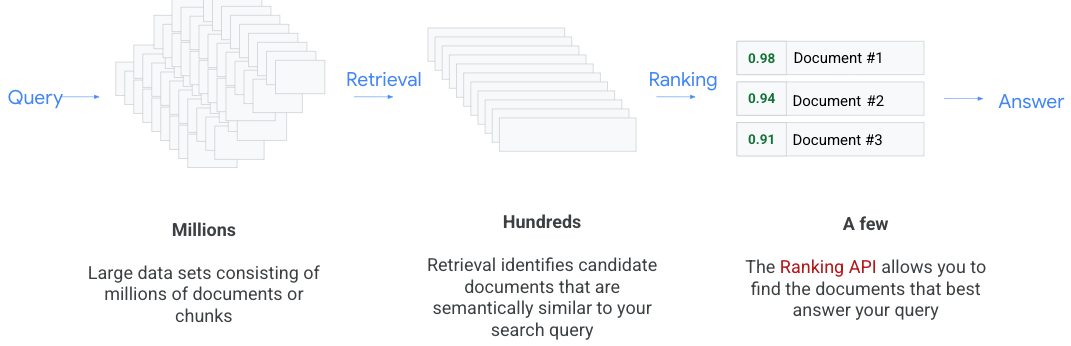

More on the Vertex Search Ranking API:

> The Vertex AI Search Ranking API is one of the standalone APIs in Vertex AI Agent Builder. It takes a list of documents and reranks those documents based on how relevant the documents are to a query. Compared to embeddings, which look only at the semantic similarity of a document and a query, the ranking API can give you precise scores for how well a document answers a given query. The ranking API can be used to improve the quality of search results after retrieving an initial set of candidate documents.

> The ranking API is stateless so there's no need to index documents before calling the API. All you need to do is pass in the query and documents. This makes the API well suited for reranking documents from any document retrievers.

>For more information, see [Rank and rerank documents](https://cloud.google.com/generative-ai-app-builder/docs/ranking).

**3.1 Define and combine retriever using Vector Search and reranker using the Vertex AI Ranking API.**

In [ ]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_google_community import VertexAIRank

# Instantiate the VertexAIReranker with the SDK manager
reranker = VertexAIRank(
    project_id=PROJECT_ID,
    location_id="global",
    ranking_config="default_ranking_config",
    title_field="source",  # metadata field to preserve with reranked results
    top_n=5,
)

basic_retriever = vector_store.as_retriever(
    search_kwargs={"k": 5}
)  # fetch top 5 documents

# Create the ContextualCompressionRetriever with the VertexAIRanker as a Reranker
retriever_with_reranker = ContextualCompressionRetriever(
    base_compressor=reranker, base_retriever=basic_retriever
)

**3.2 Examine results before and after re-ranking**

See the difference reranking makes! By prioritizing semantically relevant documents, the Ranking API improves the LLM's context, leading to more accurate and well-reasoned answers. Compare the `Retriever Results` and the `Reranked Results` side-by-side to see the improvement.

In [ ]:
reranked_results = get_sxs_comparison(
    simple_retriever=basic_retriever,
    reranking_api_retriever=retriever_with_reranker,
    query="what was google cloud revenue in 2023 ?",
    search_kwargs={"k": 5},
)

## 💬 Answer Generation

You have retrieved the most relevant facts from the all of your indexed source data.  Now we pass those facts into the LLM for answer generation, which will be grounded on the facts.

### Step 4. Query in Real Time and Check Grounding

Let's now configure a standard retrieval and answer generation chain that follows: `query` -> `vector search` -> `retrieve documents` -> `LLM for answer generation` with a couple of changes:

1. We will pass retrieved documents to the reranker API via the `VertexAIRank` and get the reranked documents to generate the answer.

2. After the answer is generated by the LLM, pass the answer and the retrieved documents from vector search as facts to the `VertexAICheckGroundingWrapper` to check how grounded the response from the LLM is.

More on the Vertex AI Check Grounding API:

> The [Vertex AI Check Grounding API](https://cloud.google.com/generative-ai-app-builder/docs/check-grounding) is one of the standalone APIs in [Vertex AI Agent Builder](https://cloud.google.com/generative-ai-app-builder/docs/builder-apis). It is used to determine how grounded a piece of text (called an answer candidate) is in a given set of reference texts (called facts).

> The Check Grounding API returns an overall support score of 0 to 1, which indicates how much the answer candidate agrees with the given facts. The response also includes citations to the facts supporting each claim in the answer candidate.

> You can use the Check Grounding API for checking any piece of text. It could be a human-generated blurb or a machine-generated response. A typical use case would be to check an LLM-generated response with respect to a given set of facts. Among other things, the citations generated by the API would help distinguish hallucinated claim in the response from grounded claims.

> For more information, see [Check Grounding](https://cloud.google.com/generative-ai-app-builder/docs/check-grounding).

**4.1 Define and configure retrieval and answer generation chain**

- Configure retreiver from the vector store previously defined

In [ ]:
from typing import List

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

from langchain.docstore.document import Document
from langchain_core.runnables import chain

from langchain_google_vertexai import VertexAI
from langchain.prompts import PromptTemplate

from langchain_google_community import VertexAICheckGroundingWrapper

from rich import print

retriever = vector_store.as_retriever(search_kwargs={"k": 5})

- Configure LLM with prompt template to generate answer

In [ ]:
llm = VertexAI(model_name="gemini-1.5-pro-001", max_output_tokens=1024)
template = """
Answer the question based only on the following context:
{context}

Question:
{query}
"""
prompt = PromptTemplate.from_template(template)

create_answer = prompt | llm

- Define wrapper to call Vertex AI Check Grounding API on the generated answer

In [ ]:
output_parser = VertexAICheckGroundingWrapper(
    project_id=PROJECT_ID,
    location_id="global",
    grounding_config="default_grounding_config",
    top_n=3,
)

- Define QA chain with Check Grounding

In [ ]:
@chain
def check_grounding_output_parser(answer_candidate: str, documents: List[Document]):
    return output_parser.with_config(configurable={"documents": documents}).invoke(
        answer_candidate
    )


setup_and_retrieval = RunnableParallel(
    {"context": retriever, "query": RunnablePassthrough()}
)


@chain
def qa_with_check_grounding(query):
    docs = setup_and_retrieval.invoke(query)
    answer_candidate = create_answer.invoke(docs)
    check_grounding_output = check_grounding_output_parser.invoke(
        answer_candidate, documents=docs["context"]
    )
    return check_grounding_output

**4.2 Invoke Generation Generation API Chain.**

In [ ]:
result = qa_with_check_grounding.invoke("what was google cloud revenue in 2023 ?")
print(result)

CheckGroundingResponse(
    support_score=0.7950530052185059,
    cited_chunks=[
        {
            'chunk_text': "# ITEM 5. MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS, AND ISSUER
PURCHASES OF EQUITY SECURITIES\n\n## COMPARISON OF CUMULATIVE 5-YEAR TOTAL RETURN*\n\nALPHABET INC. CLASS A COMMON 
STOCK Among Alphabet Inc., the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite 
Index$400$350$300$250$200$150$100$50$012/18 3/19 619 9/19/12/193/206/20 912012120 3121 6121 912112121 3122 6122 
912212122 3123 6123 9123 12123Alphabet Inc. Class A RDG Internet CompositeS&P 500*$100 invested on December 31, 
2018, in stock or index, including reinvestment of dividends. Copyright 2024 S&P, a division of The McGraw-Hill 
Companies Inc. All rights reserved.NASDAQ CompositeTable of ContentsThe graph below matches Alphabet Inc. Class C's
cumulative five-year total stockholder return on capital stock with the cumulative total returns of the S&P 500 
index, the NASDAQ Composite index, and the RDG Internet Composite index. The graph tracks the performance of a $100
investment in our Class C capital stock and in each index (with the reinvestment of all dividends) from December 
31, 2018, to December 31, 2023. The returns shown are based on historical results and are not intended to suggest 
future performance.COMPARISON OF CUMULATIVE 5-YEAR TOTAL RETURN*ALPHABET INC. CLASS C CAPITAL STOCK Among Alphabet 
Inc., the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite 
Index$400$350$300$250$200$150$100$50$012/183/196/19*$100 invested on December 31, 2018, in stock or in index, 
including reinvestment of dividends.Copyright® 2024 S&P, a division of The McGraw-Hill Companies Inc. All rights 
reserved.ITEM 6. [Reserved]9/19Alphabet Inc. Class CS&P",
            'source': Document(
                page_content="# ITEM 5. MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS, AND 
ISSUER PURCHASES OF EQUITY SECURITIES\n\n## COMPARISON OF CUMULATIVE 5-YEAR TOTAL RETURN*\n\nALPHABET INC. CLASS A 
COMMON STOCK Among Alphabet Inc., the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite 
Index$400$350$300$250$200$150$100$50$012/18 3/19 619 9/19/12/193/206/20 912012120 3121 6121 912112121 3122 6122 
912212122 3123 6123 9123 12123Alphabet Inc. Class A RDG Internet CompositeS&P 500*$100 invested on December 31, 
2018, in stock or index, including reinvestment of dividends. Copyright 2024 S&P, a division of The McGraw-Hill 
Companies Inc. All rights reserved.NASDAQ CompositeTable of ContentsThe graph below matches Alphabet Inc. Class C's
cumulative five-year total stockholder return on capital stock with the cumulative total returns of the S&P 500 
index, the NASDAQ Composite index, and the RDG Internet Composite index. The graph tracks the performance of a $100
investment in our Class C capital stock and in each index (with the reinvestment of all dividends) from December 
31, 2018, to December 31, 2023. The returns shown are based on historical results and are not intended to suggest 
future performance.COMPARISON OF CUMULATIVE 5-YEAR TOTAL RETURN*ALPHABET INC. CLASS C CAPITAL STOCK Among Alphabet 
Inc., the S&P 500 Index, the NASDAQ Composite Index, and the RDG Internet Composite 
Index$400$350$300$250$200$150$100$50$012/183/196/19*$100 invested on December 31, 2018, in stock or in index, 
including reinvestment of dividends.Copyright® 2024 S&P, a division of The McGraw-Hill Companies Inc. All rights 
reserved.ITEM 6. [Reserved]9/19Alphabet Inc. Class CS&P 500RDG Internet 
Composite12/193/206/209/2012/203/216/219/2112/213/226/229/2212/22NASDAQ Composite3/236/239/2312/23",
                metadata={
                    'chunk_id': 'c34',
                    'source': 
'gs://cloud-samples-data/gen-app-builder/search/alphabet-investor-pdfs/goog-10-k-2023.pdf'
                }
            )
        },
        {
            'chunk_text': '# Google advertisin

**4.3 Check grounding**


In [ ]:
display_grounded_generation(result)

In [ ]:
result = qa_with_check_grounding.invoke(
    "what were the downstream effects of covid on alphabet?"
)
display_grounded_generation(result)

Congratulations!  You created a search engine from source documents, and wired in a real time RAG pipeline to retrieve only the most relevant facts and include them in your LLM generated responses, and you included a grounding verification step to ensure high quality results.

If you would like to evaluate your generated answered on more dimensions, take a look at the [Vertex Eval Service metrics for RAG](https://cloud.google.com/vertex-ai/generative-ai/docs/models/evaluation-examples#rag-qa) and you can get scores and explanationals on many metrics like `question_answering_quality`, `question_answering_relevance`, `question_answering_helpfulness`, `groundedness`, `fulfillment`, `coherence`, `toxicity`, and more.

---

# 🧹 Cleaning up

Clean up resources created in this notebook.

In [ ]:
DELETE_DOCAI_PROCESSOR = False
DELETE_INDEX = False
DELETE_BUCKET = False

- **Delete datapoints from Vector Search index**

In [ ]:
# Delete datapoints from Vertex AI Vector Store


def delete_from_vector_search(
    vs_index: MatchingEngineIndex,
    vs_endpoint: MatchingEngineIndexEndpoint,
    delete: bool = False,
):
    neighbors = vs_endpoint.find_neighbors(
        deployed_index_id=vs_index.deployed_indexes[0].deployed_index_id,
        queries=[[0.0] * VS_DIMENSIONS],
        num_neighbors=5000,
        return_full_datapoint=False,
    )

    datapoint_ids = [neighbor.id for neighbor in neighbors[0]]

    # Delete datapoints
    if delete:
        print(f"Deleting {len(datapoint_ids)} datapoints")
        response = vs_index.remove_datapoints(datapoint_ids=datapoint_ids)
        print(response)


delete_from_vector_search(vs_index, vs_endpoint, delete=DELETE_INDEX)

- 🗑️ **Remove Vertex AI Vector Search Index and Endpoint**

In [ ]:
if DELETE_INDEX:
    print(f"Undeploying all indexes and deleting the index endpoint {vs_endpoint}")
    vs_endpoint.undeploy_all()
    vs_endpoint.delete()
    print(f"Deleting the index {vs_index}")
    vs_index.delete()

- 🗑️ **Remove Document AI Processor**

In [ ]:
if DELETE_DOCAI_PROCESSOR:
    docai_client = documentai.DocumentProcessorServiceClient()
    request = documentai.DeleteProcessorRequest(name=docai_processor.name)
    operation = docai_client.delete_processor(request=request)
    print("Waiting for delete processor operation to complete...")
    response = operation.result()
    print(response)

- 🗑️ **Remove Google Cloud Storage bucket**

In [ ]:
if DELETE_BUCKET:
    ! gsutil -m rm -r $STAGING_BUCKET_URI

---